# EuroSat Image Classification using SwinTransformer

Hector Becerra  
Juan Terven  
2023

The **Swin Transformer** is a neural network architecture that brings the power of Transformer models, typically used in natural language processing, into the realm of computer vision. Introduced by researchers Ze Liu, Yutong Lin, Yue Cao, et al., in 2021, the Swin Transformer stands out for its hierarchical design and the use of shifted window-based self-attention mechanisms. Unlike standard Transformers that compute attention globally, Swin Transformer limits self-attention computation to non-overlapping local windows and allows cross-window connections through shifting these windows in alternate layers. This design reduces computational complexity and enables scalability to larger image sizes and deeper networks. The Swin Transformer has shown remarkable performance on a variety of vision tasks, including image classification, object detection, and semantic segmentation, demonstrating the versatility and efficiency of applying Transformer models to visual data.

In [1]:
import os
import numpy as np 
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb
from torch.utils.data import DataLoader
import json
from torchvision.models import swin_v2_b,Swin_V2_B_Weights

from train_utils import get_predictions,compute_val_loss,EarlyStopping,train_model
from eval_utils import remove_wandb_hooks,evaluate_test_set,precision_recall_analysis
from EuroSAT import EurosatDataset,visualize_classes


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print("Found GPU")
else:
    torch.device("cpu")
    
print("Pytorch version:", torch.__version__)

Found GPU
Pytorch version: 1.13.1+cu117


## Login to Wandb to log experiment

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'EuroSat_SwinB_Classifier.ipynb'

wandb.login()

wandb: Currently logged in as: jrterven. Use `wandb login --relogin` to force relogin


True

# Data
The [EuroSat Dataset](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8736785) consists of 27,000 labeled images with ten different land use and land cover classes. It is multi-spectral, covering 13 spectral bands in the visible, near infrared, and short wave infrared parts of the spectrum. The dataset is geo-referenced and based on openly and freely accessible earth observation data. The classes are the following.

| No. | Land Use Type           |
|-----|-------------------------|
| 1   | AnnualCrop              |
| 2   | Forest                  |
| 3   | HerbaceousVegatation    |
| 4   | Highway                 |
| 5   | Industrial              |
| 6   | Pasture                 |
| 7   | PermanentCrop           |
| 8   | Residential             |
| 9   | River                   |
| 10  | SeaLake                 |

In [3]:
data_path = "C:/Users/jrtervens/Documents/data/eurosat/EuroSAT/"

In [4]:
# Load the labels 
f = open(f"{data_path}label_map.json", "r")
label_to_index = json.load(f)

In [5]:
index_to_label = {label_to_index[k]:k for k in label_to_index}
print(index_to_label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## Data Transformations

In [6]:
# Define a sequence of transformations to be applied to images
transformToTensor = transforms.Compose([
    # Resize the image to have a minimum size of 64 pixels along the shortest dimension,
    # preserving the aspect ratio of the original image.
    transforms.Resize((64,)),

    # Crop the image at the center to get a 64x64 square.
    transforms.CenterCrop((64, 64)),

    # Convert the image to a PyTorch tensor.
    transforms.ToTensor(),

    # Normalize the tensor image with mean and standard deviation for each color channel.
    # These specific values are generally used for pre-trained models.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Create dataset instances
# Instantiate the EurosatDataset class for training data.
train_dataset = EurosatDataset(_type='train', transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for validation data.
valid_dataset = EurosatDataset(_type="valid", transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for testing data.
test_dataset = EurosatDataset(_type="test", transform=transformToTensor,
                              data_path=data_path)

# Define batch sizes for training and validation data.
train_batch = 64  # The batch size for training data.
val_batch = 16     # The batch size for validation data.

# Create DataLoaders
# Create a DataLoader for the training dataset. This DataLoader will automatically
# group the training data into batches of size 128 and shuffle them in each epoch.
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)

# Create a DataLoader for the validation dataset. This DataLoader groups the validation
# data into batches of size 32. The data is not shuffled, which is typical for validation data.
valid_loader = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False)

# Create a DataLoader for the testing dataset. This DataLoader processes the test data
# one sample at a time (batch size of 1) and does not shuffle the data. This is typical
# for test data since we often want to evaluate the model on test data in a specific order.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

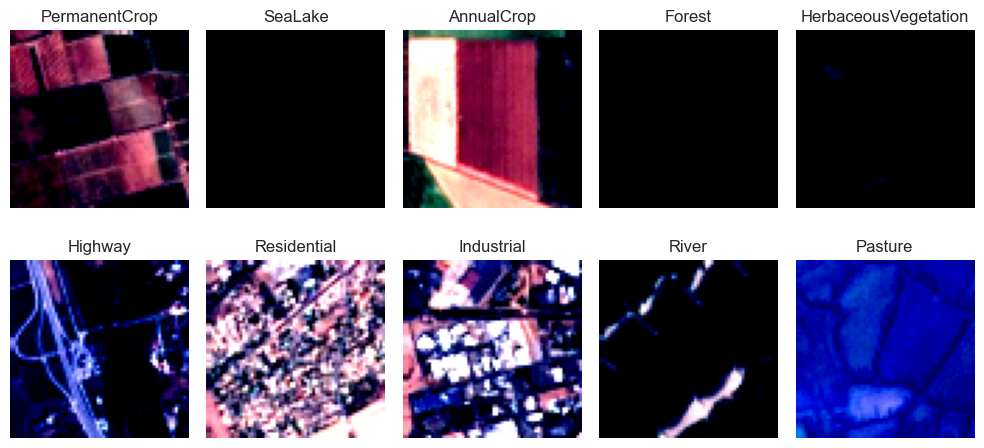

In [8]:
visualize_classes(train_loader, index_to_label)

In [9]:
dataset_managers = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader
}

print(f"Train set batches: {len(train_loader)}")
print(f"Validation set batches: {len(valid_loader)}")
print(f"Test set examples: {len(test_loader)}")

Train set batches: 296
Validation set batches: 338
Test set examples: 2700


## Labels distribution

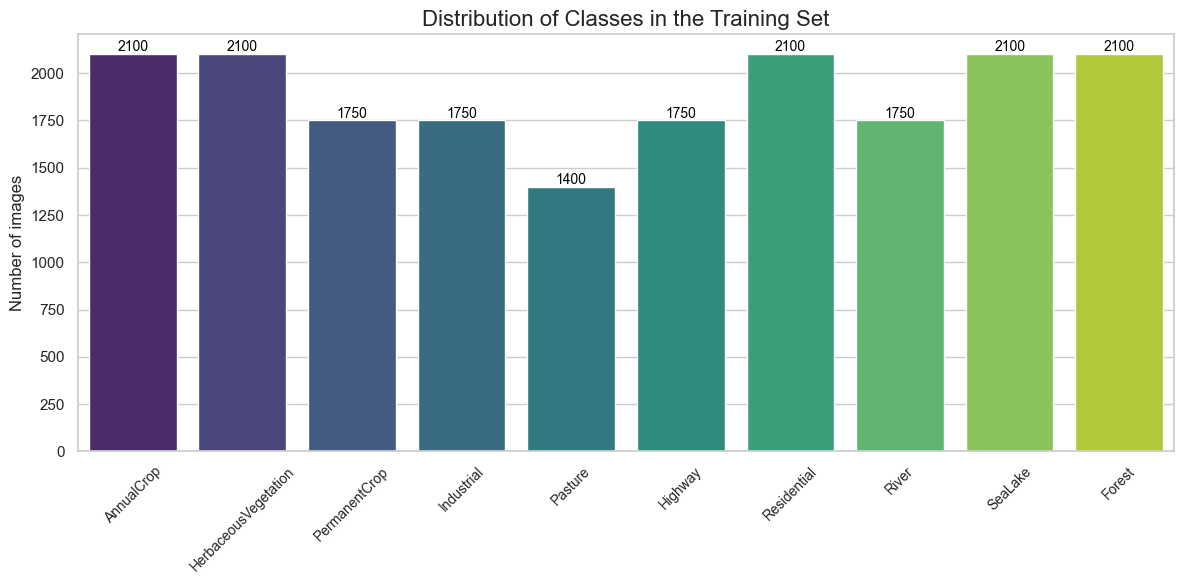

In [10]:
labels = train_dataset.data['Label'].values  # Assuming 'Label' is the column with labels

# Convert numerical labels to string names if necessary
label_names = [index_to_label[label] for label in labels]

sns.set(style="whitegrid")  # Set style
plt.figure(figsize=(12, 6))

# Adjusted according to the new API
ax = sns.countplot(x=label_names, hue=label_names, palette="viridis", legend=False)

#plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Distribution of Classes in the Training Set', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Add the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



# Model

In [11]:
# Use un-pretrained model
model = swin_v2_b()

# Replace the model head with the number of classes
num_classes = 10
model.head = nn.Linear(1024, num_classes) 
model.to(DEVICE)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

# Training model from Scratch

In [12]:
project_name = "EuroSAT"
model_name = "SwinB"
models_path = "C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/"

In [16]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="SwinB from scratch",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 2.2411262333393096
Step: 41/296 Loss: 1.7744773268699645
Step: 61/296 Loss: 1.6470024824142455
Step: 81/296 Loss: 1.6127097845077514
Step: 101/296 Loss: 1.4812015295028687
Step: 121/296 Loss: 1.6105654656887054
Step: 141/296 Loss: 1.4619401514530181
Step: 161/296 Loss: 1.347362607717514
Step: 181/296 Loss: 1.308441549539566
Step: 201/296 Loss: 1.3264626801013946
Step: 221/296 Loss: 1.2148596197366714
Step: 241/296 Loss: 1.1760603576898574
Step: 261/296 Loss: 1.1785517990589143
Step: 281/296 Loss: 1.195619198679924
Validation Loss: 1.2140 Accuracy: 0.5246
Epoch duration: 168.05s

Epoch: 2...
Step: 21/296 Loss: 1.1538262218236923
Step: 41/296 Loss: 1.000656110048294
Step: 61/296 Loss: 0.9932894468307495
Step: 81/296 Loss: 0.9767757505178452
Step: 101/296 Loss: 0.9289178192615509
Step: 121/296 Loss: 1.0248310655355453
Step: 141/296 Loss: 1.012822648882866
Step: 161/296 Loss: 0.89

Step: 41/296 Loss: 0.313208631798625
Step: 61/296 Loss: 0.3259628273546696
Step: 81/296 Loss: 0.3042039528489113
Step: 101/296 Loss: 0.2588954582810402
Step: 121/296 Loss: 0.2777009293437004
Step: 141/296 Loss: 0.29086286239326
Step: 161/296 Loss: 0.33199483156204224
Step: 181/296 Loss: 0.27035744190216066
Step: 201/296 Loss: 0.30351403504610064
Step: 221/296 Loss: 0.28816538825631144
Step: 241/296 Loss: 0.22750616408884525
Step: 261/296 Loss: 0.31064642071723936
Step: 281/296 Loss: 0.2897927530109882
Validation Loss: 0.3967 Accuracy: 0.8846
Epoch duration: 68.21s

Epoch: 15...
Step: 21/296 Loss: 0.2653138656169176
Step: 41/296 Loss: 0.23165783770382403
Step: 61/296 Loss: 0.2541580632328987
Step: 81/296 Loss: 0.2233512531965971
Step: 101/296 Loss: 0.23577711060643197
Step: 121/296 Loss: 0.2223898358643055
Step: 141/296 Loss: 0.25258670561015606
Step: 161/296 Loss: 0.2236170072108507
Step: 181/296 Loss: 0.2398506451398134
Step: 201/296 Loss: 0.20625138357281686
Step: 221/296 Loss: 0.240

Step: 61/296 Loss: 0.13794381460174918
Step: 81/296 Loss: 0.11630162112414837
Step: 101/296 Loss: 0.12107660938054324
Step: 121/296 Loss: 0.09792964588850736
Step: 141/296 Loss: 0.1498420332558453
Step: 161/296 Loss: 0.13406074959784747
Step: 181/296 Loss: 0.12241257727146149
Step: 201/296 Loss: 0.1046742545440793
Step: 221/296 Loss: 0.08741246247664095
Step: 241/296 Loss: 0.10674714082852006
Step: 261/296 Loss: 0.13353117369115353
Step: 281/296 Loss: 0.12161555718630553
Validation Loss: 0.3147 Accuracy: 0.9146
Epoch duration: 68.80s

Epoch: 28...
Step: 21/296 Loss: 0.12057182602584363
Step: 41/296 Loss: 0.13271715324372052
Step: 61/296 Loss: 0.12925534341484307
Step: 81/296 Loss: 0.1330031151883304
Step: 101/296 Loss: 0.09391605006530881
Step: 121/296 Loss: 0.13251428240910174
Step: 141/296 Loss: 0.10598207069560886
Step: 161/296 Loss: 0.12999003413133323
Step: 181/296 Loss: 0.18078356832265854
Step: 201/296 Loss: 0.1305304725654423
Step: 221/296 Loss: 0.11056558052077889
Step: 241/29

## Save model

In [17]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models\EuroSAT-SwinB.pth


In [18]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as file:
    file.write(f"loss_i: {loss_i}\n")
    file.write(f"loss_val_i: {loss_val_i}\n")

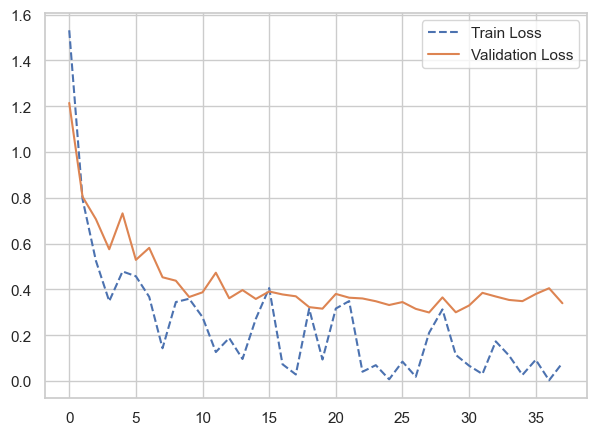

In [19]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [25]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [13]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + f"{model_name}.pth"
print(f"Loading model {model_save_path}")
model.load_state_dict(torch.load(f = model_save_path))

Loading model C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/SwinB.pth


<All keys matched successfully>

In [14]:
evaluate_test_set(model, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.915     0.937     0.926       300
              Forest      0.993     0.960     0.976       300
HerbaceousVegetation      0.937     0.893     0.915       300
             Highway      0.903     0.820     0.860       250
          Industrial      0.944     0.936     0.940       250
             Pasture      0.815     0.950     0.878       200
       PermanentCrop      0.916     0.824     0.867       250
         Residential      0.974     0.997     0.985       300
               River      0.844     0.928     0.884       250
             SeaLake      0.987     0.993     0.990       300

            accuracy                          0.926      2700
           macro avg      0.923     0.924     0.922      2700
        weighted avg      0.928     0.926     0.926      2700



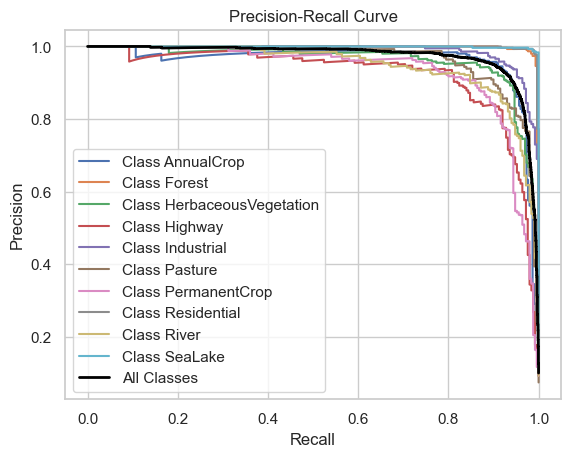

In [21]:
precision_recall_analysis(model, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [22]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▅▆▆▇▇▇▇▇▇▇▇▇▇███▇█████████████████
val_loss,█▅▄▃▄▃▃▂▂▂▂▂▁▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▂▂▁▁▂▂▁
epoch,37
step,11232
train_loss,0.07663
val_accuracy,0.91333
val_loss,0.33926


## Load the precision/recall curve and plot it

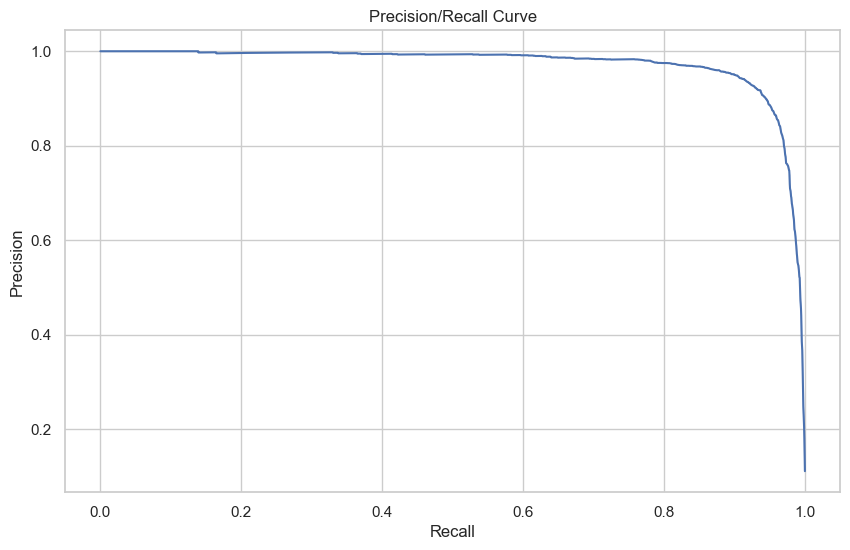

In [23]:
filename = f"{model_name}_precision_recall_values.json"
file_path = os.path.join(models_path, filename)

with open(file_path, 'r') as file:
    precision_recall_data = json.load(file)
    
all_classes_data = precision_recall_data['All Classes']

# Extract precision and recall values
precisions = all_classes_data.get('precision', [])
recalls = all_classes_data.get('recall', [])

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls
})

# Plotting the precision/recall curve
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Recall', y='Precision')
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Clean-up

In [15]:
import gc

del model
torch.cuda.empty_cache()
gc.collect()


26065

# Now train the model with pre-trained weights

In [16]:
# Use pretrained model
model2 = swin_v2_b(weights=Swin_V2_B_Weights.IMAGENET1K_V1)

# Replace the model head with the number of classes
num_classes = 10
model2.head = nn.Linear(1024, num_classes) 
model2.to(DEVICE)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

## Train

In [17]:
model_name = "SwinB-Pretrained"

In [27]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="SwinB pre-trained on ImageNet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model2, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 1.7400021463632585
Step: 41/296 Loss: 0.41446198225021363
Step: 61/296 Loss: 0.2558675304055214
Step: 81/296 Loss: 0.186379511654377
Step: 101/296 Loss: 0.16946293786168098
Step: 121/296 Loss: 0.15506500639021398
Step: 141/296 Loss: 0.13164995731785895
Step: 161/296 Loss: 0.15590749345719815
Step: 181/296 Loss: 0.12111017750576139
Step: 201/296 Loss: 0.11694626100361347
Step: 221/296 Loss: 0.09890413861721754
Step: 241/296 Loss: 0.10847763195633889
Step: 261/296 Loss: 0.13580182418227196
Step: 281/296 Loss: 0.09670588886365294
Validation Loss: 0.1504 Accuracy: 0.9585
Epoch duration: 69.74s

Epoch: 2...
Step: 21/296 Loss: 0.0724096728488803
Step: 41/296 Loss: 0.09375301923137158
Step: 61/296 Loss: 0.07656714883632958
Step: 81/296 Loss: 0.039958174794446674
Step: 101/296 Loss: 0.06778223866131157
Step: 121/296 Loss: 0.0437306820997037
Step: 141/296 Loss: 0.04477276967372745
Step

Step: 221/296 Loss: 0.007864795563727966
Step: 241/296 Loss: 0.016097894961421843
Step: 261/296 Loss: 0.003347567414311925
Step: 281/296 Loss: 0.013233622851112159
Validation Loss: 0.1096 Accuracy: 0.9741
Epoch duration: 65.99s

Epoch: 14...
Step: 21/296 Loss: 0.01822211760299979
Step: 41/296 Loss: 0.0188650568430603
Step: 61/296 Loss: 0.008202350570354611
Step: 81/296 Loss: 0.022009915640956022
Step: 101/296 Loss: 0.02005250512447674
Step: 121/296 Loss: 0.02471709077944979
Step: 141/296 Loss: 0.018415202482719904
Step: 161/296 Loss: 0.018620686585200018
Step: 181/296 Loss: 0.006816247085225768
Step: 201/296 Loss: 0.004394217969820602
Step: 221/296 Loss: 0.005897635169094429
Step: 241/296 Loss: 0.011748134930166998
Step: 261/296 Loss: 0.0047237983180821175
Step: 281/296 Loss: 0.00567527270395658
Validation Loss: 0.0844 Accuracy: 0.9806
Epoch duration: 66.36s

Epoch: 15...
Step: 21/296 Loss: 0.006662779892758408
Step: 41/296 Loss: 0.0004747648067677801
Step: 61/296 Loss: 0.0010516020485

## Save model

In [28]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models\EuroSAT-SwinB-Pretrained.pth


In [29]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as archivo:
    archivo.write(f"loss_i: {loss_i}\n")
    archivo.write(f"loss_val_i: {loss_val_i}\n")

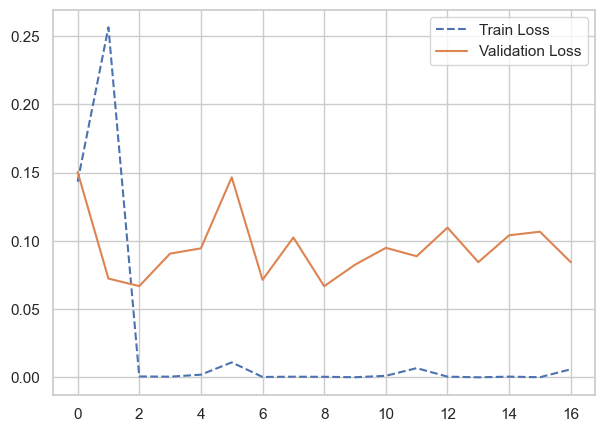

In [30]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [31]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [18]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + f"{model_name}.pth"
print(f"Loading model {model_save_path}")
model2.load_state_dict(torch.load(f = model_save_path))

Loading model C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/SwinB-Pretrained.pth


<All keys matched successfully>

In [19]:
evaluate_test_set(model2, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.993     0.980     0.987       300
              Forest      1.000     0.993     0.997       300
HerbaceousVegetation      0.971     0.990     0.980       300
             Highway      0.969     0.988     0.978       250
          Industrial      1.000     0.996     0.998       250
             Pasture      0.990     0.975     0.982       200
       PermanentCrop      0.972     0.964     0.968       250
         Residential      0.997     1.000     0.998       300
               River      0.976     0.976     0.976       250
             SeaLake      1.000     1.000     1.000       300

            accuracy                          0.987      2700
           macro avg      0.987     0.986     0.986      2700
        weighted avg      0.987     0.987     0.987      2700



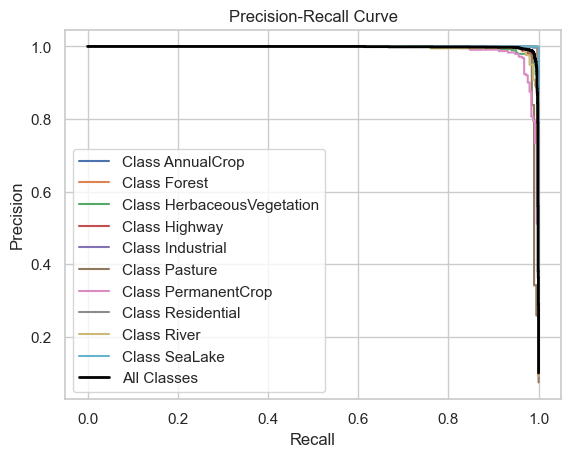

In [33]:
precision_recall_analysis(model2, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [34]:
wandb.finish()

epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▄▃▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆█▆▆▂█▇▇█▆▆▅▇▆▅█
val_loss,█▁▁▃▃█▁▄▁▂▃▃▅▂▄▄▂
epoch,16
step,5016
train_loss,0.01037
val_accuracy,0.98167
val_loss,0.08434
